# Notebook setup

# Import bibliotek

In [50]:
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse

import requests
from PIL import Image
from docling_core.types.doc import ImageRefMode
from docling_core.types.doc.document import DocTagsDocument, DoclingDocument
from mlx_vlm import load, generate
from mlx_vlm.prompt_utils import apply_chat_template
from mlx_vlm.utils import load_config, stream_generate

import pandas as pd

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Baza danych SQLite

In [5]:
import sqlite3
sqlite_connection = sqlite3.connect("ecclesia.db")
# test połączenia
cursor = sqlite_connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
if tables:
    print("Połączono")
    print("Dostępne tabele:", tables)
else:
    print("Problem z połączeniem")

Połączono
Dostępne tabele: [('dane_hasla',)]


In [27]:
ROOT_DIRECTORY

'/Users/user/Projects/ecclesiasticalOCR'

/Users/user/Projects/ecclesiasticalOCR/data/schematyzmy/wloclawek_1872/0071.jpg


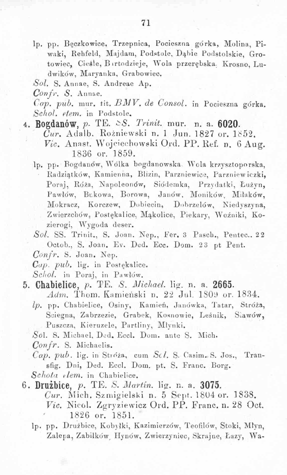

In [45]:
import os
from IPython.display import display
from PIL import Image


ROOT_DIRECTORY = os.path.dirname(os.getcwd())
# walidacje robimy na schematyzmie wloclawek 1872
image_dir = "data/schematyzmy/wloclawek_1872"
ABSOLUTE_IMAGE_DIRECTORY = os.path.join(ROOT_DIRECTORY, image_dir)

image_files = [f for f in os.listdir(ABSOLUTE_IMAGE_DIRECTORY) if f.endswith('.jpg')]

#wczytajmy i wyswietlmy jakis skan
for i, image_file in enumerate(image_files):
    image_path = os.path.join(ABSOLUTE_IMAGE_DIRECTORY, image_file)
    print(image_path)
    with open(image_path, 'rb') as img_file:
         img = Image.open(img_file)
         img = img.resize((img.width // 4, img.height // 4))
         display(img)
    break # konczymy po 5 skanach


In [53]:
import pandas as pd

# wczytajmy dane z bazy danych do dataframe
query = "SELECT * FROM dane_hasla WHERE skany = 'wloclawek_1872'"
skany_df = pd.read_sql_query(query, sqlite_connection)

# wyświetlmy dane z dataframe
skany_df

,id,dekanat,diecezja,parafia,miejsce,typ_obiektu,wezwanie,wezwanie_par,material_typ,the_geom,strona_p,strona_k,skany,faksymile
0,26291,Włocławek,Włocławek,Włocławek,Włocławek,kościół parafialny,Jan Chrzciciel,[brak informacji],mr,MULTIPOLYGON (((36.253799987793 2317.444700012...,10,10,wloclawek_1872,
1,26292,Włocławek,Włocławek,Boniewo,Boniewo,kościół parafialny,Nawiedzenie Najświętszej Maryi Panny,[brak informacji],dr,MULTIPOLYGON (((40.233799987793006 2319.132700...,11,11,wloclawek_1872,
2,26293,Włocławek,Włocławek,Brześć,Brześć,kościół parafialny,Stanisław Biskup Męczennik,[brak informacji],mr,MULTIPOLYGON (((40.217799987793 2318.020700012...,11,11,wloclawek_1872,
3,26294,Włocławek,Włocławek,Choceń,Choceń,kościół parafialny,Idzi Opat,[brak informacji],dr,MULTIPOLYGON (((40.237799987793 2316.304700012...,11,11,wloclawek_1872,
4,26295,Włocławek,Włocławek,Chodecz,Chodecz,kościół parafialny,Dominik Guzmán,[brak informacji],mr,MULTIPOLYGON (((40.205799987793 2315.248700012...,11,12,wloclawek_1872,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,26627,Radomsk,Włocławek,Rzejowice,Rzejowice,kościół parafialny,Wszyscy Św.,,dr,MULTIPOLYGON (((380.27599996948 2315.658999992...,96,96,wloclawek_1872,
334,26628,Radomsk,Włocławek,Sulmierzyce,Sulmierzyce,kościół parafialny,Erazm Biskup Męczennik,,mr,MULTIPOLYGON (((380.29599996948 2314.318999992...,96,97,wloclawek_1872,
335,26629,Radomsk,Włocławek,Wielgomłyny,Wielgomłyny,kościół parafialny,Stanisław Biskup Męczennik,,mr,MULTIPOLYGON (((384.24799996948 2317.766999992...,97,97,wloclawek_1872,
336,26630,Radomsk,Włocławek,Wiewiec,Wiewiec,kościół parafialny,Marcin Biskup,,mr,MULTIPOLYGON (((384.25599996948006 2315.862999...,96,96,wloclawek_1872,


## Model OCR

In [6]:


#ustawienia doclinga
SHOW_IN_BROWSER = True  #eksportuje output do html i otwiera w przeglądarce

# loading modelu
model_path = "ds4sd/SmolDocling-256M-preview-mlx-bf16"
model, processor = load(model_path)
config = load_config(model_path)

#główny prompt
prompt = "Convert this page to docling."

# Apply chat template
formatted_prompt = apply_chat_template(processor, config, prompt, num_images=1)



output = ""
for token in stream_generate(
    model, processor, formatted_prompt, [image], max_tokens=4096, verbose=False
):
    output += token.text
    print(token.text, end="")
    if "</doctag>" in token.text:
        break

print("\n\n")

# Populate document
doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([output], [pil_image])
# create a docling document
doc = DoclingDocument(name="SampleDocument")
doc.load_from_doctags(doctags_doc)

## Export as any format


NameError: name 'load' is not defined